In [1]:
import pandas as pd
import numpy as np
import math, string, json
import matplotlib.pyplot as plt 

In [2]:
price_dfs = pd.concat(
    [
        pd.read_csv(f"..\\data\\round2\\prices_round_2_day_{i}.csv", sep=';')
        .assign(timestamp=lambda df: ((i + 1) * 1_000_000 + df['timestamp']))
        for i in range(-1, 2)
    ],
    ignore_index=True
)

price_dfs['best_bid'] = price_dfs[['bid_price_1', 'bid_price_2', 'bid_price_3']].max(axis=1, skipna=True)
price_dfs['best_ask'] = price_dfs[['ask_price_1', 'ask_price_2', 'ask_price_3']].min(axis=1, skipna=True)
price_dfs

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,best_bid,best_ask
0,-1,0,CROISSANTS,4304,112,NaN,NaN,NaN,NaN,4305,112,NaN,NaN,NaN,NaN,4304.5,0.0,4304.0,4305.0
1,-1,0,JAMS,6670,66,6669.0,137.0,NaN,NaN,6671,66,6672.0,137.0,NaN,NaN,6670.5,0.0,6670.0,6671.0
2,-1,0,SQUID_INK,2005,1,2002.0,31.0,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2005.5,0.0,2005.0,2006.0
3,-1,0,PICNIC_BASKET1,59284,20,59283.0,18.0,NaN,NaN,59294,2,59295.0,36.0,NaN,NaN,59289.0,0.0,59284.0,59294.0
4,-1,0,PICNIC_BASKET2,30606,20,30605.0,18.0,NaN,NaN,30612,20,30613.0,18.0,NaN,NaN,30609.0,0.0,30606.0,30612.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,1,2999900,JAMS,6519,204,NaN,NaN,NaN,NaN,6521,204,NaN,NaN,NaN,NaN,6520.0,0.0,6519.0,6521.0
239996,1,2999900,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0,9995.0,10005.0
239997,1,2999900,SQUID_INK,1799,20,NaN,NaN,NaN,NaN,1802,20,NaN,NaN,NaN,NaN,1800.5,0.0,1799.0,1802.0
239998,1,2999900,PICNIC_BASKET1,58713,15,58712.0,21.0,NaN,NaN,58724,15,58725.0,21.0,NaN,NaN,58718.5,0.0,58713.0,58724.0


In [3]:
mid_price = price_dfs.pivot_table(index='timestamp', columns='product', values='mid_price')
best_bid = price_dfs.pivot_table(index='timestamp', columns='product', values='best_bid')
best_ask = price_dfs.pivot_table(index='timestamp', columns='product', values='best_ask')

In [4]:
strats = ["ARB1", "ARB2"]
arb_prods = {
    "ARB1": ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1'],
    "ARB2": ['CROISSANTS', 'JAMS', 'PICNIC_BASKET2']
}
arb_coefs = {
    "ARB1": [6, 3, 1, -1],
    "ARB2": [4, 2, -1],
}

for arb in strats:
    mid_price[arb] = (
        mid_price[arb_prods[arb]] * arb_coefs[arb]
    ).sum(axis=1)

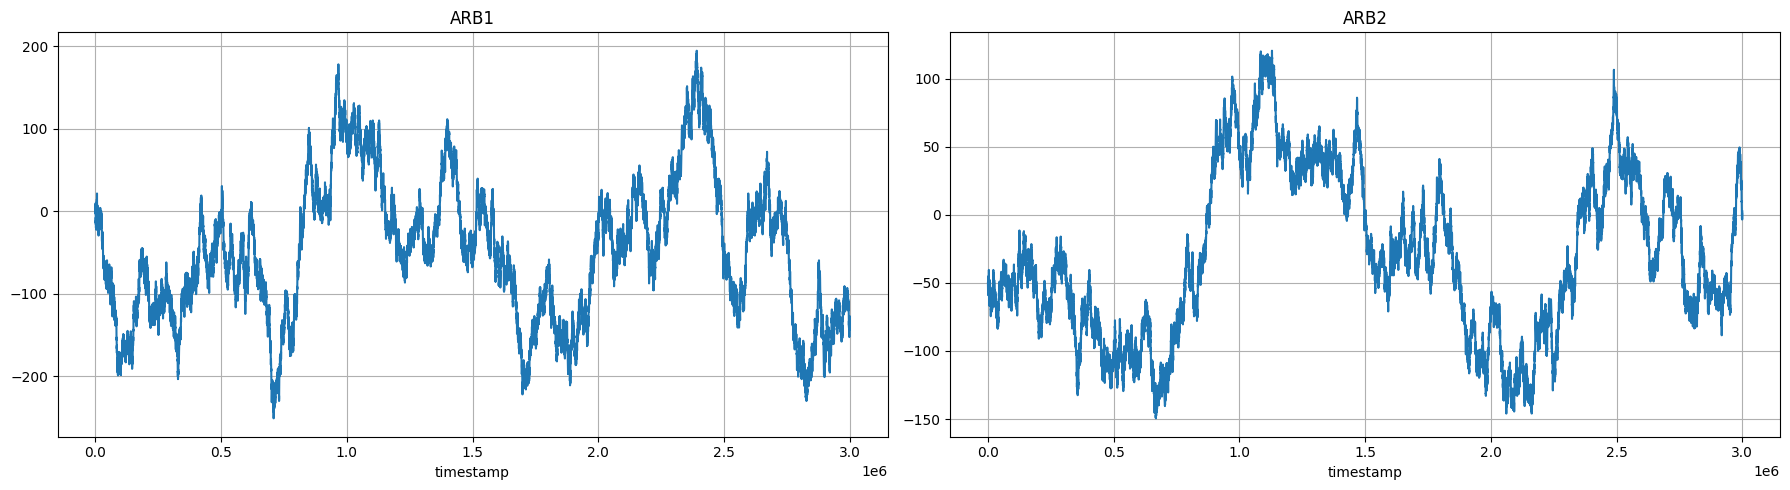

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

for ax, arb, title in zip(axes, strats, strats):
    mid_price[arb].plot(ax=ax)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

# Threshold Calculator
We aim to set thresholds that maximize profit from the spread. We set up a list of thresholds, that when crossed, bring our position to a new value.
Adding more thresholds reduces the efficacy of each swing but increases the amount of swings captured.

## Testing Mechanism
Have a list of possible thresholds, along with their associated positions. This list will be mirrored: negative thresholds will use the negative of their associated positions. 

When a threshold is reached, positions will be adjusted to automatically buy/sell shares at best prices from the orderbook. The highest possible position is the position limit, referencing the real position limits if applied to only one stat-arb strategy.

Total PnL will be tracked throughout the backtest, and displayed at the end.

In [15]:
def gen_signal(thresholds, std):
    if abs(std) <= thresholds[0]:
        return 0
    elif abs(std) >= thresholds[1]:
        return 1 if std > 0 else -1
    else:
        return -0.5

In [16]:
def price_synth(arb: str, long: bool, cost: bool, i: int):
    if cost:
        total = 0

        for prod, coef in zip(arb_prods[arb], arb_coefs[arb]):
            if long and coef > 0 or not long and coef < 0:
                total += best_ask[prod].iloc[i] * abs(coef)
            else:
                total -= best_bid[prod].iloc[i] * abs(coef)
        return total
    else:
        total = 0
        for prod, coef in zip(arb_prods[arb], arb_coefs[arb]):
            total += mid_price[prod].iloc[i] * coef
        return total


def statarb_bt(thresholds: list[float], arb_position: int, cost: bool, arb: str):
    position = 0 
    spent = 0

    pnl_list = []
    pos_list = []
    std_list = []
    signals = []
    price_list = []

    sigma = mid_price[arb].std()
    mean = mid_price[arb].mean()
    print(f"mean = {mean}, std = {sigma}")
    
    for i in range(len(mid_price[arb])):
        std = (mid_price[arb].iloc[i] - mean) / sigma
        signal = gen_signal(thresholds, std)
        new_pos = position
        if signal == 1:
            new_pos = -arb_position # sell
        elif signal == -1:
            new_pos = arb_position # buy
        elif signal == 0:
            new_pos = 0 # neutralize

        # Calculate pnl
        shift = new_pos - position
        if shift == 0:
            price = 0
        else:
            price = price_synth(arb, shift > 0, cost, i)
        
        position = new_pos
        spent += price * shift
        pnl = -spent
        if position != 0:
            for prod, coef in zip(arb_prods[arb], arb_coefs[arb]):
                pnl += mid_price[prod].iloc[i] * coef * position


        pos_list.append(position)
        price_list.append(price)
        pnl_list.append(pnl)
        std_list.append(std)
        signals.append(signal)

    return pnl, pos_list, std_list, price_list, signals

mean = -48.762433333333334, std = 85.11945080948944


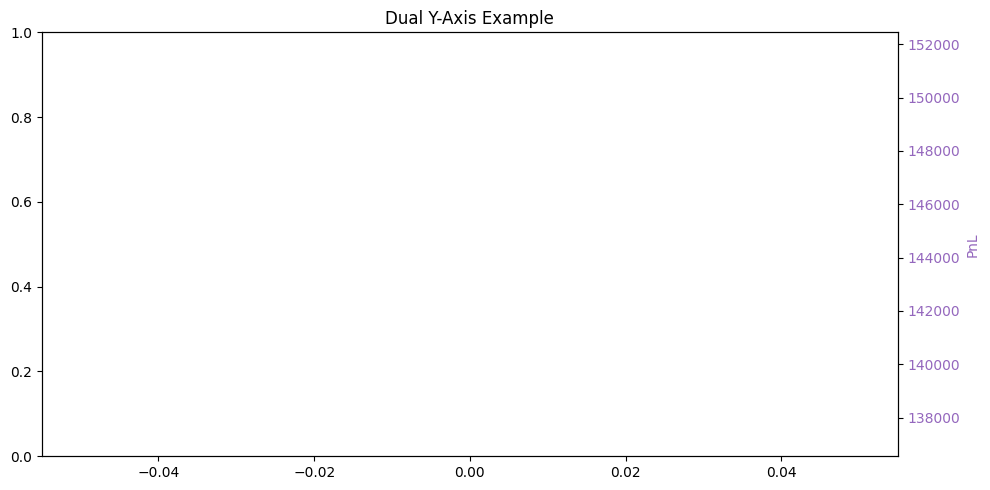

In [ ]:
# plot pnl vs. range(pivot_df.shape[0])

thresholds = [0.25, 1.75]
arb_position = 100
pnl, pos_list, std_list, price_list, signals = statarb_bt(thresholds, arb_position, True, "ARB1")
fig, ax1 = plt.subplots(figsize=(10, 5))

# ax1.plot(signals, color='tab:blue', label='Signal')
# ax1.set_ylabel('signal', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2 = ax1.twinx()
# ax2.plot(pos_list, color='tab:green', label='Signals')
# ax2.set_ylabel('Signals', color='tab:green')
# ax2.tick_params(axis='y', labelcolor='tab:green')

# ax3 = ax1.twinx()
# ax3.plot(std_list, color='tab:red', label='Basket Price')
# ax3.set_ylabel('Basket Price', color='tab:red')
# ax3.tick_params(axis='y', labelcolor='tab:red')

# ax4 = ax1.twinx()
ax4.plot(pnl, color='tab:purple', label='PnL')
ax4.set_ylabel('PnL', color='tab:purple')
ax4.tick_params(axis='y', labelcolor='tab:purple')

plt.title("Dual Y-Axis Example")
plt.tight_layout()
plt.show()

In [14]:
old_df = pd.read_csv("..\\data\\round2\\prices_round_2_day_-1.csv", sep=';')
new_df = pd.read_csv("..\\data\\round2_new\\prices_round_2_day_-1.csv", sep=';')
key = "RAINFOREST_RESIN"
old_key = old_df[old_df['product'] == key]
new_key = new_df[new_df['product'] == key]
old_key.head(15)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
5,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
11,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0
16,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0
29,-1,300,RAINFOREST_RESIN,9996,2,9995.0,29.0,NaN,NaN,10004,2,10005.0,29.0,NaN,NaN,10000.0,0.0
37,-1,400,RAINFOREST_RESIN,9996,2,9995.0,25.0,NaN,NaN,10004,2,10005.0,25.0,NaN,NaN,10000.0,0.0
43,-1,500,RAINFOREST_RESIN,9995,30,NaN,NaN,NaN,NaN,10002,4,10005.0,30.0,NaN,NaN,9998.5,0.0
48,-1,600,RAINFOREST_RESIN,10000,5,9995.0,25.0,NaN,NaN,10005,25,NaN,NaN,NaN,NaN,10002.5,0.0
61,-1,700,RAINFOREST_RESIN,9995,23,NaN,NaN,NaN,NaN,10005,23,NaN,NaN,NaN,NaN,10000.0,0.0
69,-1,800,RAINFOREST_RESIN,9996,1,9995.0,29.0,NaN,NaN,10004,1,10005.0,29.0,NaN,NaN,10000.0,0.0
75,-1,900,RAINFOREST_RESIN,9996,1,9995.0,22.0,NaN,NaN,10004,1,10005.0,22.0,NaN,NaN,10000.0,0.0


In [67]:
new_key.head(15)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
5,-1,0,RAINFOREST_RESIN,10001,1,9997.0,7.0,9992.0,25.0,10008,25,NaN,NaN,NaN,NaN,10004.5,0.0
11,-1,100,RAINFOREST_RESIN,9992,29,NaN,NaN,NaN,NaN,10008,29,NaN,NaN,NaN,NaN,10000.0,0.0
16,-1,200,RAINFOREST_RESIN,9992,34,NaN,NaN,NaN,NaN,10008,34,NaN,NaN,NaN,NaN,10000.0,0.0
29,-1,300,RAINFOREST_RESIN,9992,35,NaN,NaN,NaN,NaN,10008,35,NaN,NaN,NaN,NaN,10000.0,0.0
37,-1,400,RAINFOREST_RESIN,9992,27,NaN,NaN,NaN,NaN,10008,27,NaN,NaN,NaN,NaN,10000.0,0.0
43,-1,500,RAINFOREST_RESIN,9992,31,NaN,NaN,NaN,NaN,10008,31,NaN,NaN,NaN,NaN,10000.0,0.0
48,-1,600,RAINFOREST_RESIN,9992,34,NaN,NaN,NaN,NaN,10008,34,NaN,NaN,NaN,NaN,10000.0,0.0
61,-1,700,RAINFOREST_RESIN,9992,34,NaN,NaN,NaN,NaN,10008,34,NaN,NaN,NaN,NaN,10000.0,0.0
69,-1,800,RAINFOREST_RESIN,9992,30,NaN,NaN,NaN,NaN,10003,7,10008.0,30.0,NaN,NaN,9997.5,0.0
75,-1,900,RAINFOREST_RESIN,9992,30,NaN,NaN,NaN,NaN,10008,30,NaN,NaN,NaN,NaN,10000.0,0.0
